In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure



In [2]:
X_train = pd.read_csv('../../datasets/Bikerental/X_train.csv',index_col=0)  
X_test = pd.read_csv('../../datasets/Bikerental/X_test.csv',index_col=0)  
y_train = pd.read_csv('../../datasets/Bikerental/y_train.csv',index_col=0)  
y_test = pd.read_csv('../../datasets/Bikerental/y_test.csv',index_col=0)  
from sklearn.model_selection import train_test_split

# Specify the split ratio. For example, let's use 80% for training and 20% for validation
split_ratio = 0.2

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=split_ratio, random_state=42)


In [3]:
X_train

,yr,temp,hum,windspeed,days_since_2011,season_FALL,season_SPRING,season_SUMMER,season_WINTER,holiday_HOLIDAY,workingday_WORKING DAY,weathersit_GOOD,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
6,2011,1.236534,49.8696,11.304642,6,0,0,0,1,0,1,0,1,0
328,2011,9.625000,64.3750,6.626019,328,1,0,0,0,0,1,1,0,0
601,2012,25.017500,61.5000,4.833769,601,0,0,1,0,0,1,0,1,0
729,2012,4.024151,48.3333,23.500518,729,0,0,0,1,0,0,1,0,0
231,2011,24.782500,67.4167,6.999289,231,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2011,25.605000,30.5000,19.583229,152,0,1,0,0,0,1,1,0,0
547,2012,30.344151,51.8750,11.291443,547,0,0,1,0,0,0,1,0,0
18,2011,5.732178,74.1739,13.957239,18,0,0,0,1,0,1,0,1,0
484,2012,13.541651,58.7083,7.832836,484,0,1,0,0,0,0,1,0,0


In [4]:
X_train.columns

Index(['yr', 'temp', 'hum', 'windspeed', 'days_since_2011', 'season_FALL',
       'season_SPRING', 'season_SUMMER', 'season_WINTER', 'holiday_HOLIDAY',
       'workingday_WORKING DAY', 'weathersit_GOOD', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM'],
      dtype='object')

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [6]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, hidden_layers, hidden_units, dropout, dropout_array, input_dim, output_dim, activation=nn.ReLU(),norm=False):
        if hidden_layers != len(hidden_units):
            print("Error: wrong size of hidden_layers or hidden_units")
            return
        layers = []
        i = 0
        if norm:
            layers.append(nn.BatchNorm1d(input_dim))

        super(Net, self).__init__()
        
        layers.append(nn.Linear(input_dim, hidden_units[i]))
        layers.append(activation)
        if dropout:
            layers.append(nn.Dropout(dropout_array[i]))

        for _ in range(hidden_layers - 1):
            i += 1
            layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
            layers.append(activation)
            if dropout:
                layers.append(nn.Dropout(dropout_array[i]))

        layers.append(nn.Linear(hidden_units[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [7]:
config = {
    'hidden_layers': 3,
    'hidden_units': [128, 128, 64],
    'dropout': False,
    'dropout_array': [0.5, 0.3225943639867505, 0.6472032609256847],
    'activation': nn.ReLU(),
    'norm': False,
    'lr':0.005,
    'batch_size':8,
    'num_epochs':400
    
}

input_dim = X_train_scaled.shape[1]
output_dim = 1

In [8]:
train_ds = TensorDataset(torch.Tensor(X_train_scaled), torch.Tensor(y_train.to_numpy()))
val_ds = TensorDataset(torch.Tensor(X_val_scaled), torch.Tensor(y_val.to_numpy()))
test_ds = TensorDataset(torch.Tensor(X_test_scaled), torch.Tensor(y_test.to_numpy()))

In [9]:
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"])
test_loader = DataLoader(test_ds, batch_size=config["batch_size"])

In [10]:
net = Net(hidden_layers=config["hidden_layers"], hidden_units=config["hidden_units"], dropout=config["dropout"], dropout_array=config["dropout_array"], input_dim=input_dim, output_dim=output_dim, activation=config["activation"], norm=config["norm"])

In [17]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
net = net.to(device)

In [18]:
summary(net,input_size=(14,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,920
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
Total params: 26,753
Trainable params: 26,753
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [19]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [20]:
criterion = RMSELoss()
optimizer = optim.Adam(net.parameters(), lr=config["lr"])

In [21]:
def train_net(net, train_loader, criterion, optimizer, device):
    net.train()
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader), net


def test_net(net, test_loader, criterion, device):
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    return test_loss / len(test_loader)


def train(config):
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=config["batch_size"])
    net = Net(hidden_layers=config["hidden_layers"], hidden_units=config["hidden_units"], dropout=config["dropout"], dropout_array=config["dropout_array"], input_dim=input_dim, output_dim=output_dim, activation=config["activation"], norm=config["norm"])
    criterion = RMSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    patience = 10
    early_stop = False

    for epoch in range(config["num_epochs"]):
        train_loss,net = train_net(net, train_loader, criterion, optimizer, device)
        val_loss = test_net(net, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{config['num_epochs']}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 10
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping...")
                early_stop = True
                break

    if not early_stop:
        print("Training complete.")

    return train_losses, val_losses, net



In [22]:
train_losses, val_losses, mod = train(config)

Epoch [1/400], Train Loss: 3442.1810, Test Loss: 1001.3705
Epoch [2/400], Train Loss: 921.7737, Test Loss: 881.2956
Epoch [3/400], Train Loss: 852.1152, Test Loss: 769.7973
Epoch [4/400], Train Loss: 837.3354, Test Loss: 761.6779
Epoch [5/400], Train Loss: 784.5442, Test Loss: 825.1875
Epoch [6/400], Train Loss: 798.3571, Test Loss: 746.5342
Epoch [7/400], Train Loss: 747.8358, Test Loss: 841.0931
Epoch [8/400], Train Loss: 795.9026, Test Loss: 759.2865
Epoch [9/400], Train Loss: 742.0338, Test Loss: 711.8354
Epoch [10/400], Train Loss: 729.8265, Test Loss: 713.1759
Epoch [11/400], Train Loss: 713.7585, Test Loss: 734.1555
Epoch [12/400], Train Loss: 739.4851, Test Loss: 707.4133
Epoch [13/400], Train Loss: 721.1755, Test Loss: 681.9432
Epoch [14/400], Train Loss: 724.3208, Test Loss: 770.4530
Epoch [15/400], Train Loss: 690.9416, Test Loss: 709.1404
Epoch [16/400], Train Loss: 680.0908, Test Loss: 806.8600
Epoch [17/400], Train Loss: 671.6137, Test Loss: 697.3474
Epoch [18/400], Train

In [23]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

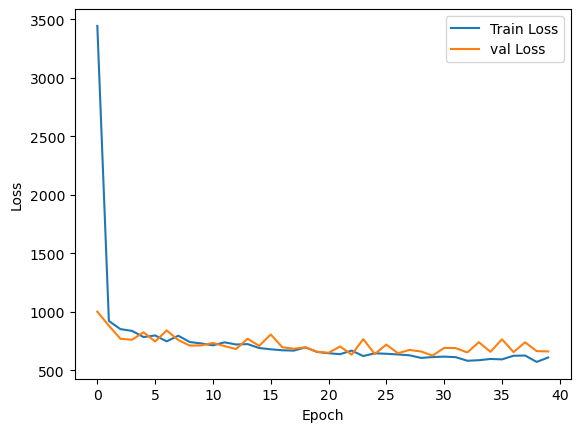

In [24]:
plot_losses(train_losses, val_losses)

In [25]:
def plot_predictions(net, data_loader, device):
    net.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = net(inputs)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    plt.scatter(y_true, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    ss_tot = np.sum((y_true - y_bar) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


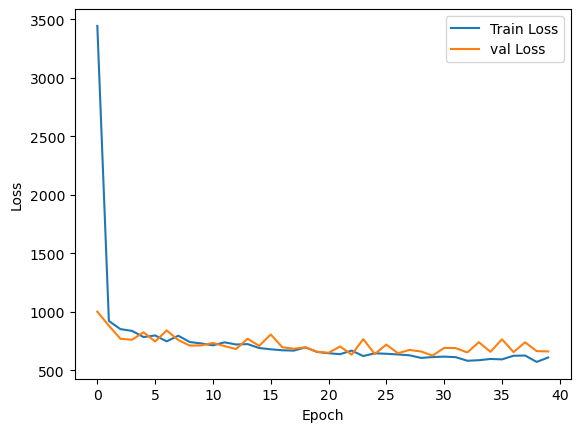

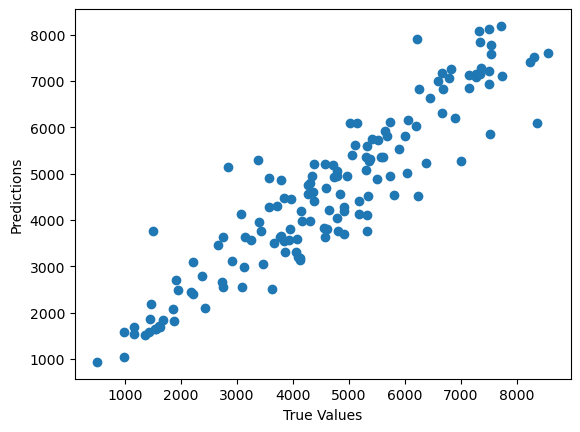

R^2 score: 0.8524499682064746
Train_loss: 581.4302978515625
Validation_loss: 743.0172729492188
Test_loss: 729.1561889648438


C:\Users\Patrick\AppData\Local\Temp\ipykernel_32060\2864887404.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_true = np.array([y for _, y in test_ds])
C:\Users\Patrick\AppData\Local\Temp\ipykernel_32060\2864887404.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([y for _, y in test_ds])


In [26]:
#train_losses, test_losses = train(config)
plot_losses(train_losses, val_losses)
plot_predictions(mod, test_loader, device)
y_true = np.array([y for _, y in test_ds])
y_pred = mod(torch.Tensor(X_test_scaled).to(device)).cpu().detach().numpy()
r2 = r2_score(y_true, y_pred)
print("R^2 score:", r2)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_val_tensor = torch.Tensor(y_val.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)
print("Train_loss:",criterion(mod(torch.Tensor(X_train_scaled).to(device)),y_train_tensor).item())
print("Validation_loss:",criterion(mod(torch.Tensor(X_val_scaled).to(device)),y_val_tensor).item())
print("Test_loss:",criterion(mod(torch.Tensor(X_test_scaled).to(device)),y_test_tensor).item())


In [28]:
torch.save(mod, '../../Models/bike_rental_model_85')

In [14]:
net = torch.load('./Models/bike_rental_model_85')
net.eval()

Net(
  (net): Sequential(
    (0): Linear(in_features=14, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)